In [4]:
# Check RAM Memory

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')
  
print(ram_gb)

# Login into drive

from google.colab import drive
drive.mount('/content/drive')

# Importing "load_model"

from keras.models import load_model

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!
89.63678208
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import numpy as np
from tensorflow.keras import optimizers

# Download and import data preprocessing .py file
!wget https://raw.githubusercontent.com/DiSanchz/satellite_imagery_econ_indicators/main/satellite_imagery_econ_indicators/data_processing.py
from data_processing import data_bundle as data_bundle

# Download and import performance metrics .py file
!wget https://raw.githubusercontent.com/DiSanchz/satellite_imagery_econ_indicators/main/satellite_imagery_econ_indicators/performance_metrics.py
from performance_metrics import plot_ROC, plot_cm, plot_acc_loss
from sklearn.metrics import classification_report

# Download and import VGG16 .py file
! wget https://raw.githubusercontent.com/DiSanchz/satellite_imagery_econ_indicators/main/satellite_imagery_econ_indicators/VGG16.py
from VGG16 import vgg16_seei as vgg16_class

# Download and import VGG16 .py file

--2023-05-15 15:41:30--  https://raw.githubusercontent.com/DiSanchz/satellite_imagery_econ_indicators/main/satellite_imagery_econ_indicators/data_processing.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3955 (3.9K) [text/plain]
Saving to: ‘data_processing.py.1’

data_processing.py. 100%[===================>]   3.86K  --.-KB/s    in 0s      

2023-05-15 15:41:30 (90.8 MB/s) - ‘data_processing.py.1’ saved [3955/3955]

--2023-05-15 15:41:31--  https://raw.githubusercontent.com/DiSanchz/satellite_imagery_econ_indicators/main/satellite_imagery_econ_indicators/performance_metrics.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubuserco

In [6]:
# Define relevant paths for appropriately instantiating the data_bundle class
images_path_0 = "/content/drive/MyDrive/Thesis/M224A-1000/inputs/images_224A_1000.npy"
popn_path_0 = "/content/drive/MyDrive/Thesis/M224A-1000/inputs/popn_224A_1000.npy"
target_var = "gdp"

# In this case GDP has been chose
if target_var == "gdp":
  labels_path_0 = "/content/drive/MyDrive/Thesis/M224A-1000/inputs/gdp_224A_1000.npy"
  label_type = "GDPpercap"

elif target_var == "hdi":
  labels_path_0 = "/content/drive/MyDrive/Thesis/M224A-1000/inputs/hdi_224A_1000.npy"
  label_type = "HDI"

# Instantiate data_bundle object
basic_bundle = data_bundle(images_path_0, popn_path_0, labels_path_0, label_type, augmented=True)

# Preprocess data through the data_bundle class' methods
basic_bundle.normalize_images()
basic_bundle.normalize_popn()
basic_bundle.bundle_inputs()
basic_bundle.split_data(0.4,0.5,2023)
basic_bundle.unbundle_and_shape_inputs()
basic_bundle.onehot_encode_labels()

# The resulting input sets are: self.X_tri, self.X_vai, self.X_tei (Images) and self.X_trp, self.X_vap, self.X_tep (Population)
# The resulting tragets are: self.y_train_onehot, self.y_val_onehot and self.y_test_onehot
# Where "self" is to be substituted by the given name to the data_bundle instance

/content/data_processing.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  features = np.array(list(zip(self.images, np.array(self.popn))))


### Model: VGG16 - GDP per capita

In [7]:
# Eliminar learning rate de vgg.py y pasar el dropout a argumento de método y no de clase
vgg_model = vgg16_class(input_shape=(224, 224, 3))

vgg_model.load_and_freeze_vgg16()
vgg_model.enable_dual_input()
vgg_model.add_dense_layers(dropout_rate=0.25)
optimizer = sgd = optimizers.SGD(learning_rate=0.005)
vgg_model.define_and_compile_model(optimizer=optimizer)
vgg_model.fit_model(train_in=[basic_bundle.X_tri, basic_bundle.X_trp], train_tar=basic_bundle.y_train_onehot, 
                    validation_in=[basic_bundle.X_vai, basic_bundle.X_vap], validation_tar=basic_bundle.y_val_onehot, 
                    batch_size=80, epochs=100, es_patience=25)

# Note: if model is on single mode train_in and validation_in should have just one "input" instead of a list of two "inputs"

vgg_model.predict([basic_bundle.X_tei, basic_bundle.X_tep])

# model Save/Load  

example_save_path = "/content/drive/MyDrive/Thesis/vgg16_v0.h5"
example_load_path = "/content/drive/MyDrive/Thesis/vgg16_v0.h5"

#vgg_model.save(<path_here>)
#vgg_model.load(<path_here>)

58889256/58889256 [==============================] - 1s 0us/step
Epoch 1/100
47/47 [==============================] - 20s 172ms/step - loss: 1.3902 - accuracy: 0.2953 - val_loss: 1.3625 - val_accuracy: 0.3668
Epoch 2/100
47/47 [==============================] - 3s 74ms/step - loss: 1.3693 - accuracy: 0.3067 - val_loss: 1.3281 - val_accuracy: 0.3772
Epoch 3/100
47/47 [==============================] - 3s 74ms/step - loss: 1.3531 - accuracy: 0.3155 - val_loss: 1.2991 - val_accuracy: 0.4139
Epoch 4/100
47/47 [==============================] - 3s 74ms/step - loss: 1.3407 - accuracy: 0.3312 - val_loss: 1.2811 - val_accuracy: 0.4266
Epoch 5/100
47/47 [==============================] - 3s 75ms/step - loss: 1.3191 - accuracy: 0.3496 - val_loss: 1.2622 - val_accuracy: 0.4386
Epoch 6/100
47/47 [==============================] - 3s 73ms/step - loss: 1.2933 - accuracy: 0.3746 - val_loss: 1.2166 - val_accuracy: 0.4386
Epoch 7/100
47/47 [==============================] - 3s 74ms/step - loss: 1.2767 

In [8]:
vgg_model.predict([basic_bundle.X_tei, basic_bundle.X_tep])

40/40 [==============================] - 1s 21ms/step


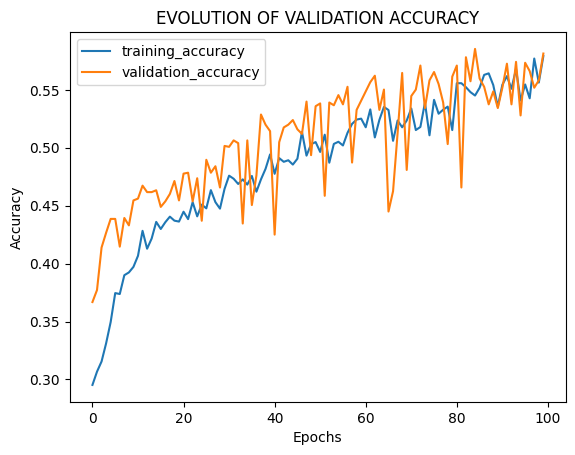

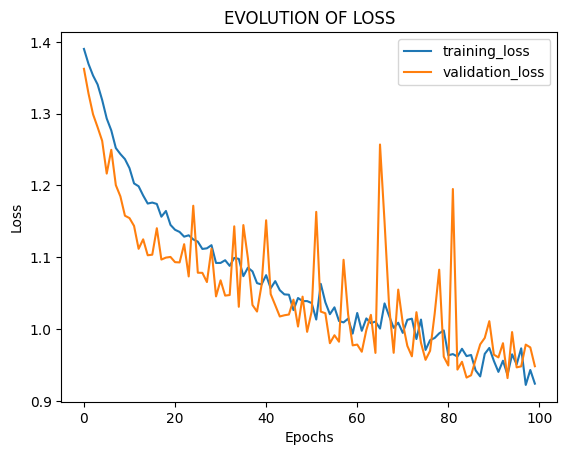

In [9]:
# Val acc. and Val loss evolution
plot_acc_loss(vgg_model.fit)

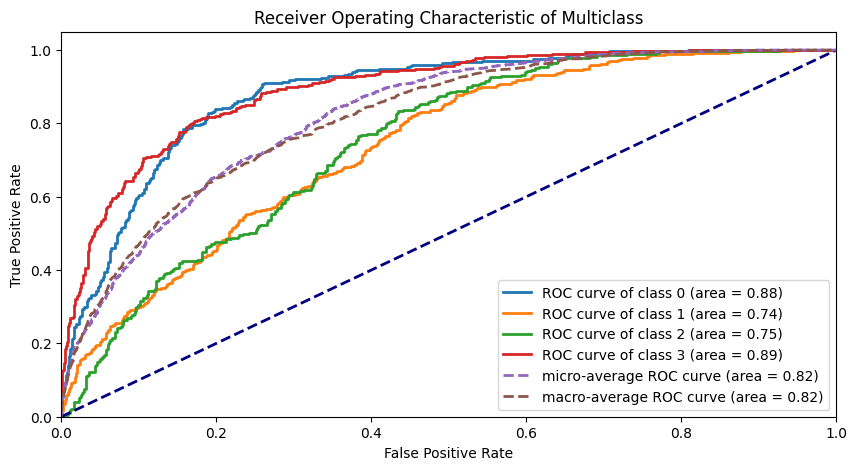

In [10]:
# ROC curves
plot_ROC(vgg_model.predictions,basic_bundle.y_test_onehot,4)

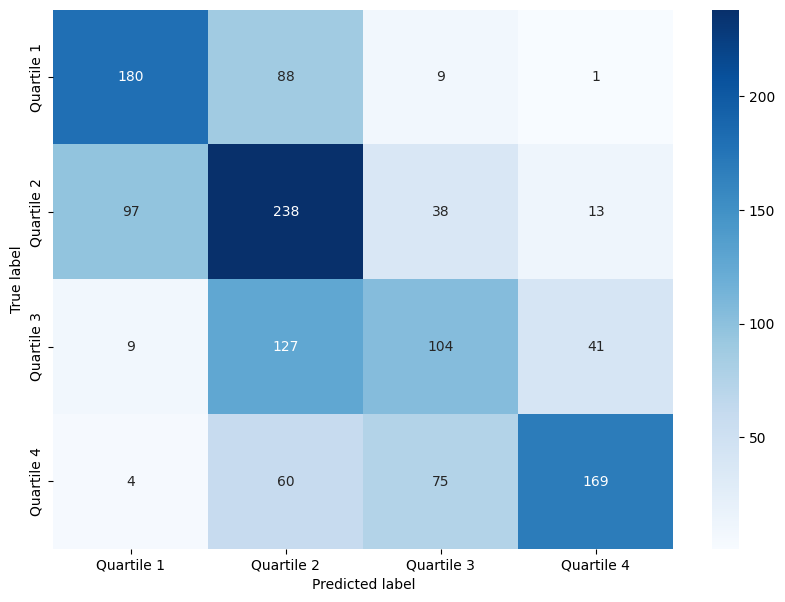

In [11]:
# Confusion matrix
plot_cm(basic_bundle.y_test_onehot,vgg_model.predictions)

In [12]:
# Clasification report
print(classification_report(np.argmax(basic_bundle.y_test_onehot, axis=1), np.argmax(vgg_model.predictions, axis=1)))

              precision    recall  f1-score   support

           0       0.62      0.65      0.63       278
           1       0.46      0.62      0.53       386
           2       0.46      0.37      0.41       281
           3       0.75      0.55      0.64       308

    accuracy                           0.55      1253
   macro avg       0.57      0.55      0.55      1253
weighted avg       0.57      0.55      0.55      1253



In [13]:
#vgg_model.save("/content/drive/MyDrive/Thesis/M224A-1000/vgg16_gdp_224A_1000_v1.h5")